In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as Data
import copy
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline as bi
%matplotlib inline

In [11]:
print(torch.__version__)
torch.set_default_tensor_type(torch.FloatTensor)
train_data = pd.read_csv("df.csv")
test_data = pd.read_csv("test.csv")
print(train_data.shape)
n_train = train_data.shape[0]
n_test = test_data.shape[0]
train_labels = torch.tensor(train_data.Step.values, dtype = torch.float).view(-1, 1)
test_labels = torch.tensor(test_data.Step.values, dtype=torch.float).view(-1, 1)
# train_data
all_features = train_data.iloc[:, 1:]
train_features = torch.tensor(all_features[:].values, dtype=torch.float)
all_features = test_data.iloc[:, 1:]
test_features = torch.tensor(all_features[:].values, dtype=torch.float)

1.10.2
(200257, 19)


In [3]:
print(train_features.shape)
print(train_labels.shape)

torch.Size([200257, 18])
torch.Size([200257, 1])


In [4]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
loss = torch.nn.MSELoss()
num_hidden = [3, 4, 5]
drop_prob = [0.2, 0.5, 0.7]
def get_net(feature_num):
    net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(feature_num, num_hidden[0]),
        nn.ReLU(),
        #nn.Dropout(drop_prob[0]),
        nn.Linear(num_hidden[0], num_hidden[1]),
        nn.ReLU(),
        #nn.Dropout(drop_prob[1]),
        #nn.Linear(num_hidden[1], num_hidden[2]),
        nn.ReLU(),
        #nn.Dropout(drop_prob[2]),
        nn.Linear(num_hidden[1], 1)
    )
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()


all_features = pd.concat((train_data.iloc[:, 0], train_data.iloc[:, 2]), axis=1)
all_features = np.concatenate((all_features.values[:,0], all_features.values[:,1])).reshape(n_train,-1)
train_features = None
print(train_features)
for i in range(n_train):
    list1 = all_features[i][0][1:-1].split(',')
    list2 = all_features[i][1][1:-1].split(',')
    array1 = np.array(list1, dtype=int)
    array2 = np.array(list2, dtype=int)
    temp_array = np.concatenate((array1, array2))
    temp_torch = torch.from_numpy(temp_array)
    if train_features == None :
        train_features = copy.deepcopy(temp_torch)
    else:
        train_features = torch.cat([train_features, temp_torch], axis=0)
    print(train_features.shape)
train_features = train_features.view(n_train, -1)

In [6]:
torch.save(train_labels, 'train_labels.csv')
torch.save(train_features, 'train_features.csv')

In [14]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = Data.TensorDataset(train_features, train_labels)
    train_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            # print(l.item())
        #train_ls.append(log_rmse(net, train_features, train_labels))
        train_ls.append(loss(net(train_features), train_labels).item())
        #print(train_ls[-1])
        if test_labels is not None:
            #test_ls.append(log_rmse(net, test_features, test_labels))
            test_ls.append(loss(net(test_features), test_labels).item())
        #if epoch % 10 == 0:
        #    print(f"train loss{train_ls[-1]}, test loss{test_ls[-1]}")
        
    return train_ls, test_ls


In [15]:
def use_svg_display():
    bi.set_matplotlib_formats('svg')
    
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=":")
        plt.legend(legend)
    plt.show()

In [9]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print(f"fold {i}, train loss{train_ls[-1]}, valid loss{valid_ls[-1]}")
        
    return train_l_sum / k, valid_l_sum / k


train loss33.628814697265625, test loss33.72736740112305
train loss3.6128451824188232, test loss3.604062557220459
train loss4.189805030822754, test loss4.200002193450928
train loss7.631601810455322, test loss7.640368461608887
train loss4.2979302406311035, test loss4.277952671051025
train loss3.8378286361694336, test loss3.81656813621521
train loss5.0775909423828125, test loss5.0331830978393555
train loss25.775556564331055, test loss25.854324340820312
train loss21.53002166748047, test loss21.605060577392578
train loss4.485795974731445, test loss4.502099990844727


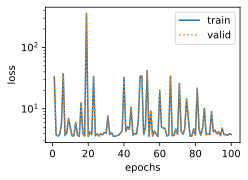

fold 0, train loss3.8058509826660156, valid loss3.8170878887176514
train loss4.341084003448486, test loss4.37679386138916
train loss5.305716514587402, test loss5.34755802154541
train loss33.76612854003906, test loss33.864715576171875
train loss3.9622395038604736, test loss3.953740119934082
train loss33.5632209777832, test loss33.661460876464844
train loss3.7506258487701416, test loss3.6841468811035156
train loss4.084403991699219, test loss4.103071689605713
train loss3.730198621749878, test loss3.727628469467163
train loss3.8516972064971924, test loss3.8004841804504395
train loss3.6589128971099854, test loss3.6438357830047607


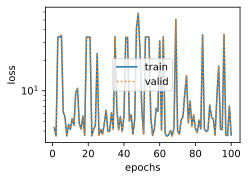

fold 1, train loss3.6612846851348877, valid loss3.6986865997314453
train loss3.5814647674560547, test loss3.580828905105591
train loss3.9425408840179443, test loss3.980663776397705
train loss6.958975791931152, test loss6.888322830200195
train loss4.027988910675049, test loss4.0683979988098145
train loss3.634002685546875, test loss3.64255952835083
train loss4.276891231536865, test loss4.252946376800537
train loss6.613992214202881, test loss6.613795757293701
train loss4.207736492156982, test loss4.269773006439209
train loss3.6218228340148926, test loss3.6404240131378174
train loss5.641575813293457, test loss5.691426753997803


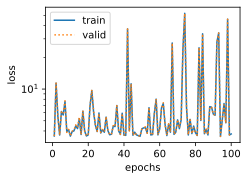

fold 2, train loss3.745685577392578, valid loss3.762371301651001
train loss4.0118632316589355, test loss4.041831970214844
train loss4.550499439239502, test loss4.557617664337158
train loss3.569276809692383, test loss3.5833117961883545
train loss7.0200300216674805, test loss7.074804782867432
train loss3.716789960861206, test loss3.7646968364715576
train loss4.010878086090088, test loss4.041162967681885
train loss4.004431247711182, test loss3.9642693996429443
train loss3.636820077896118, test loss3.6551108360290527
train loss4.629881381988525, test loss4.669989585876465
train loss3.8541297912597656, test loss3.86236310005188


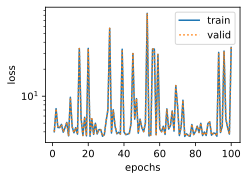

fold 3, train loss34.982215881347656, valid loss35.39653396606445
train loss3.8554635047912598, test loss3.946396827697754
train loss7.4459452629089355, test loss7.4365644454956055
train loss3.681520938873291, test loss3.701204776763916
train loss4.9578633308410645, test loss4.962276458740234
train loss4.019766330718994, test loss4.0249786376953125
train loss4.054135322570801, test loss4.085045337677002
train loss33.62496566772461, test loss33.653465270996094
train loss4.974472999572754, test loss5.011098384857178
train loss3.7031362056732178, test loss3.7211484909057617
train loss33.91262435913086, test loss33.9412727355957


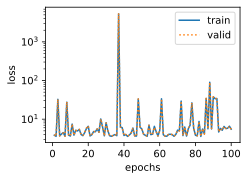

fold 4, train loss5.522965431213379, valid loss5.447903156280518
5-fold validation: avg train rmse:10.343600511550903, avg valid rmse:10.424516582489014


In [10]:
k = 5
num_epochs = 100
lr = 0.5
weight_decay = 3
batch_size = 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f"{k}-fold validation: avg train rmse:{train_l}, avg valid rmse:{valid_l}")

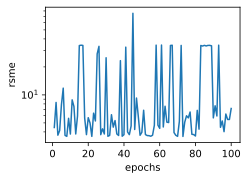

train loss:7.140440940856934
test loss:38.82563400268555


In [16]:
def train_and_pred(train_features, test_features, train_labels, test_labels, num_epochs, lr, weihgt_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rsme')
    print(f'train loss:{train_ls[-1]}')
    preds = net(test_features).detach().numpy()
    # test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    result = loss(net(test_features), test_labels).item()
    print(f"test loss:{result}")
train_and_pred(train_features, test_features, train_labels, test_labels, num_epochs, lr, weight_decay, batch_size)

